<a href="https://colab.research.google.com/github/GatienVilain/projet-impression-3d/blob/main/projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
import time

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
# On se déplace dans notre espace de travail.
# Prévoir le dossier où se placer ou modifier le chemin ci-dessous.
%cd "/content/gdrive/MyDrive/projet impression 3d"

/content/gdrive/MyDrive/projet impression 3d


Faites un raccourcis du dataset dans le dossier correspondant au chemin ci-dessus:

[Lien Google Drive du dataset](https://drive.google.com/drive/folders/1_MU7jTR0kTt8MFQYrUzWiWc6uM-BHG_9?usp=drive_link)

# Préparation des données

In [25]:
dataset_path = 'dataset_colab' # Chemin du dataset par rapport à l'espace de travail (par defaut: projet impression 3d)
RESIZE_SIZE = (255, 255)       # Résolution sous laquelle les images sont redimensionné en entrée du modèle

In [17]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, RESIZE_SIZE) # Force la taille d'une image pour qu'elle corresponde à celle utilisée lors de l'entraînement
    img = img / 255.0                  # Normalisez les valeurs des pixels
    img = np.expand_dims(img, axis=0)  # Ajoutez une dimension pour représenter le lot (batch)

    return img

In [18]:
def load_data(dataset_path):
    data = [] # Liste des images contenu dans dataset_path
    labels = [] # Liste des labels de chaque image

    # Pour chaque image contenu dans dataset_path,
    # l'importe puis la prépare pour l'entrainement
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            label = folder.lower()   # Utilisez le nom du dossier comme label
            print(label)

            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, RESIZE_SIZE) # Force la taille d'une image pour qu'elle corresponde à celle utilisée lors de l'entraînement
                data.append(img)
                labels.append(label)

    data = np.array(data) / 255.0    # Normalisez les valeurs des pixels
    labels = np.array(labels)

    return data, labels

In [26]:
def shuffle_data(data, labels):
    combined_data = list(zip(data,labels))

    # Mélange les données
    random.shuffle(combined_data)

    # Divisez à nouveau la liste combinée en deux listes distinctes
    data,labels = zip(*combined_data)

    labels = np.array(labels)
    data = np.array(data)

    return data, labels

In [19]:
data, labels = load_data(dataset_path)

ok
bed_not_stick
spaghetti


In [20]:
# On défini un dictionnaire de mapping (catégorie -> numéro) pour chaque labels précédement listé
categorie_mapping = {
    "ok": 0,
    "bed_not_stick": 1,
    "spaghetti": 2
}

# Utiliser NumPy pour convertir les catégories en numéros
labels = np.array([categorie_mapping[c] for c in labels])

In [29]:
print('Taille du dataset: ', len(labels))
print('Catégorie de la dernière image: ', labels[-1])

Taille du dataset:  422
Catégorie de la dernière image:  1


In [30]:
data, labels = shuffle_data(data, labels)

In [31]:
print('Taille du dataset: ', len(labels))
print('Catégorie de la dernière image: ', labels[-1])

Taille du dataset:  422
Catégorie de la dernière image:  1


# Création du modèle

In [36]:
drop_out = 0.3
model = keras.Sequential([
    layers.Conv2D(64, (7, 7), activation='relu', input_shape=(*RESIZE_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (4, 4), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(drop_out),
    layers.Dense(64, activation='relu'),
    layers.Dropout(drop_out),
    layers.Dense(32, activation='relu'),
    layers.Dropout(drop_out),

    layers.Dense(len(categorie_mapping), activation='softmax')
])

# Compilez le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 249, 249, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 124, 124, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 121, 128)     131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 128)               5

In [37]:
from keras.callbacks import ModelCheckpoint

# Décommenter la ligne ci-dessous pour sauvegarder le meilleur modèle. (Attention assez lourd !)
#checkpoint = ModelCheckpoint('meilleur_modele.h5', monitor='val_accuracy', save_best_only=True)

In [38]:
# Entraine le modèle.
# Décommenter la ligne correspondante pour sauvegarder ou non le meilleur modèle. (voir la cellule précédente)
model.fit(data, labels, epochs=15, validation_split=0.20, batch_size=8)
#model.fit(data, labels, epochs=15, validation_split=0.20, batch_size=8, callbacks=[checkpoint])

Epoch 1/15


KeyboardInterrupt: ignored

In [ ]:
# Décommenter pour sauvegarde le modèle actuel
#model.save('88-83.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def predict_defect_multi_class(model, image_path):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    #print (model.predict(preprocessed_img))

    # Interprétez les prédictions
    class_labels = [ 'OK','bed_not_stick', 'spaghetti']
    predicted_class = class_labels[np.argmax(predictions)]

    return predicted_class

In [ ]:
def predict(dir):
    resultf=""
    nb_total=0
    nb_positif=0
    for filename in os.listdir(dir):
        #print(filename)
        nb_total+=1

        result = predict_defect_multi_class(model, dir +"/" + filename)
        if result.upper()==dir[4:].upper():
            nb_positif+=1

        resultf= resultf + "prédiction pour"+ filename + " : "+ str(result) +"\n"

    print (resultf)
    print(str((nb_positif*100)/nb_total) + " % de précision")


In [ ]:
predict("testok")

1/1 [==============================] - 0s 18ms/step
prédiction pourok.jpg : OK
prédiction pourspaghetti.jpg : OK
prédiction pourok3.jpg : OK
prédiction pourok4.jpg : OK
prédiction pourok5.png : spaghetti
prédiction pourWIN_20231010_15_02_24_Pro.jpg : OK
prédiction pourWIN_20231010_15_02_40_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_00_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_09_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_11_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_18_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_24_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_29_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_56_Pro.jpg : OK
prédiction pourWIN_20231010_15_03_58_Pro.jpg : OK
prédiction pourWIN_20231010_15_04_02_Pro.jpg : OK
prédiction pourWIN_20231010_15_04_05_Pro.jpg : OK

94.11764705882354 % de précision


In [ ]:
predict("testspaghetti")

1/1 [==============================] - 0s 19ms/step
prédiction pourfailedprint2_img_5eb0af2d67ead.jpg : spaghetti
prédiction pourspaghetti_11_jpg.rf.8f8ab1a10807e3e51c4075a1a018ce3b.jpg : spaghetti
prédiction pourspaghetti_91_jpg.rf.2b147f68c7718049a4c11374c5f190be.jpg : spaghetti
prédiction pourimag-12-_jpg.rf.30b4d2d01cbe881c76ffb7cd4aa30d4c.jpg : OK
prédiction pourDv-Hh80U0AABjlw_jpg.rf.6116d29abb60be092c1930f2765318db.jpg : spaghetti
prédiction pourspaghetti_52_jpg.rf.66888e51d1873df0cae0aaa48e07369f.jpg : OK
prédiction pourspaghetti_73_jpg.rf.5c6d77c9cee2ba4df4e3052c8e9ecdc3.jpg : spaghetti
prédiction pourspaghetti_70_jpg.rf.02d93e279aaca215b2131a0cc614507a.jpg : spaghetti
prédiction pourimag-33-_jpg.rf.b622576485c907754e8ec87e4e5360f8.jpg : spaghetti
prédiction pourspaghetti_46_jpg.rf.49d9ad2fa0574bc52cc150c824177b79.jpg : spaghetti
prédiction pourimag-90-_jpg.rf.4b9eacbcb46c3c32db58fb5f7c22ed4c.jpg : spaghetti
prédiction pourspaghetti_49_jpg.rf.2f51e66161f920f5704ae3e81e089435.j

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def vignette_random(dir):
  L=[]
  for filename in os.listdir(dir):
    L.append(filename)
  file_alea = L[random.randint(0, (len(L)-1))]
  image_path = dir +"/" + file_alea
  result = predict_defect_multi_class(model, image_path)
  img = Image.open(image_path)
  plt.imshow(img)
  plt.axis('off')  # Masquer les axes
  plt.show()

  print (result)


1/1 [==============================] - 0s 21ms/step


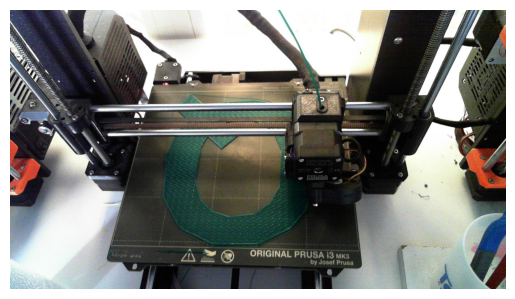

OK


In [ ]:
vignette_random("testok")

1/1 [==============================] - 0s 21ms/step


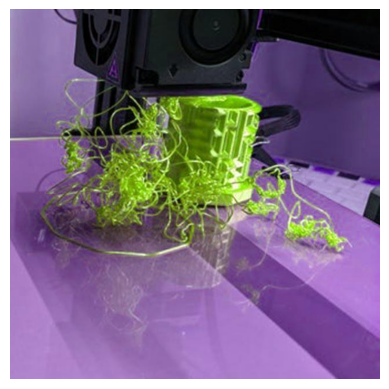

spaghetti


In [ ]:
vignette_random("testspaghetti")

In [ ]:
def capture():
  # Ouvrir la webcam (la webcam par défaut a l'ID 0)
  cap = cv2.VideoCapture(0)

  # Vérifier si la webcam est ouverte correctement
  if not cap.isOpened():
      print("Erreur: Impossible d'ouvrir la webcam.")
      exit()

  # Capturer une image
  time.sleep(1)
  ret, frame = cap.read()

  # Sauvegarder l'image capturée
  if ret:
      cv2.imwrite("photo_capturee.jpg", frame)
      print("Photo capturée avec succès.")
  else:
      print("Erreur lors de la capture de la photo.")

  # Libérer la webcam
  cap.release()
  time.sleep(1)


  result = predict_defect_multi_class(model, 'photo_capturee.jpg')
  print(f"Prédiction pour la capture camera: {result}")